In [7]:
import numpy as np
import astropy.units as u
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt
# from mhealpy import HealpixMap
from astropy.io import fits
import csv
import glob
from scipy.interpolate import interp1d

import pandas as pd
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff, MapDataset, MapDatasetOnOff
from gammapy.estimators import SensitivityEstimator
from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker, MapDatasetMaker
from gammapy.maps import MapAxis, RegionGeom, Map, WcsGeom, RegionNDMap
from gammapy.modeling.models import (
    TemplateSpatialModel, PowerLawNormSpectralModel, SkyModel, FoVBackgroundModel, Models, 
    PowerLawSpectralModel, GaussianSpatialModel
)

In [8]:
energy_axis = MapAxis.from_energy_bounds("0.03 TeV", "30 TeV", nbin=20)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.01 TeV", "100 TeV", nbin=100, name="energy_true"
)
migra_axis = MapAxis.from_bounds(
    0.5, 2, nbin=150, node_type="edges", name="migra"
)



livetime = 50.0 * u.hr

source_coord = SkyCoord.from_name("Geminga")

# geom = RegionGeom.create(
#     f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 10)", 
#     # binsz_wcs=0.02 * u.deg,
#     axes=[energy_axis])
# geom = RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 100)", axes=[energy_axis], binsz_wcs=0.02 * u.deg)

pointing = source_coord


geom = WcsGeom.create(
    skydir=pointing,
    width=(10, 10),
    binsz=0.05,
    frame="icrs",
    axes=[energy_axis, energy_axis_true],
)

empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

geom

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'energy_true']
	shape      : (200, 200, 20, 100)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 98.5 deg, 17.8 deg
	width      : 10.0 deg x 10.0 deg
	wcs ref    : 98.5 deg, 17.8 deg

In [9]:
geom

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'energy_true']
	shape      : (200, 200, 20, 100)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 98.5 deg, 17.8 deg
	width      : 10.0 deg x 10.0 deg
	wcs ref    : 98.5 deg, 17.8 deg

In [12]:
irfs = load_cta_irfs(
    # "$GAMMAPY_DATA/1.0/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits",
    "./Prod5-South-20deg-SouthAz-14MSTs37SSTs.18000s-v0.1.fits.gz"
    # "$GAMMAPY_DATA/1.0/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)
location = observatory_locations["cta_south"]
pointing = SkyCoord.from_name("Geminga")


In [13]:
obs = Observation.create(
    pointing=pointing, irfs=irfs, livetime=livetime, location=location
)

spectrum_maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])
# spectrum_dataset = spectrum_maker.run(empty_dataset, obs)

containment = 0.68

# correct exposure
# spectrum_dataset.exposure *= containment

# correct background estimation
on_radii = obs.psf.containment_radius(
    energy_true=energy_axis.center, offset=0.5 * u.deg, fraction=containment
)
# factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.width))
# spectrum_dataset.background *= factor.value.reshape(spectrum_dataset.background.data.shape)


In [14]:
filename = "allenergies_TeV.fits"
m = Map.read(filename)

m = m.copy(unit="1 / (cm2 TeV s sr)")

spatial_model = TemplateSpatialModel(m, filename=filename, normalize=False)
# spatial_model = GaussianSpatialModel(lon_0=source_coord.ra, lat_0=source_coord.dec, sigma="0.5 deg", frame="icrs")
# Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(), spatial_model=spatial_model, name="Geminga-template-model")
# Geminga_model = SkyModel(spectral_model=PowerLawSpectralModel(amplitude=5e-10/u.cm**2/u.s/u.TeV), spatial_model=spatial_model, name="Geminga-template-model")
Geminga_model = SkyModel(spectral_model=PowerLawNormSpectralModel(amplitude=1/u.cm**2/u.s/u.TeV), spatial_model=spatial_model, name="Geminga-template-model")


# m.plot_grid()

# bkg_spectral_model = PowerLawSpectralModel(
#     index=2.7, amplitude="1e6 cm-2 s-1 TeV-1", reference="1 TeV")

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
#bkg_model = FoVBackgroundModel(spectral_model=bkg_spectral_model, dataset_name="dataset-simu")

#models = Models([bkg_model])
models = Models([Geminga_model,bkg_model])
print(models)

print(models.to_yaml())

Template file already exits, and overwrite is False


Models

Component 0: SkyModel

  Name                      : Geminga-template-model
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         


components:
-   name: Geminga-template-model
    type: SkyModel
    spectral:
        type: PowerLawNormSpectralModel

In [ ]:
# Geminga_model.integrate_geom(RegionGeom.create(f"icrs;circle({source_coord.ra.deg - 0.1}, {source_coord.dec.deg}, 100)", 
#     axes=[energy_axis, energy_axis_true], 
#     binsz_wcs=0.02 * u.deg))

[]

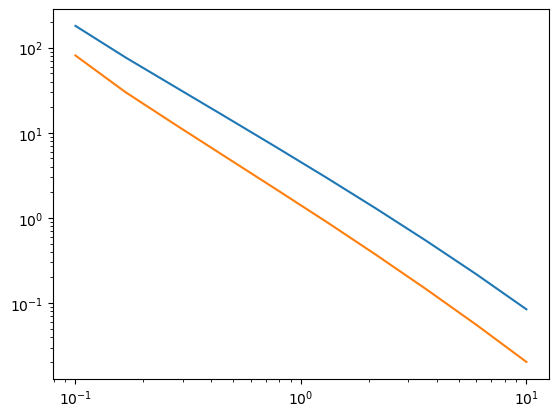

In [15]:
en = np.logspace(-1,1, 10)*u.TeV
flux = ((Geminga_model.evaluate(source_coord.ra, source_coord.dec, energy=en)*1*u.TeV*1*u.TeV).to(u.eV/u.cm**2/u.s/u.sr)*((3*u.deg)**2)).\
    to(u.eV/u.cm**2/u.s)

flux2 = ((Geminga_model.evaluate(source_coord.ra+1*u.deg, source_coord.dec, energy=en)*1*u.TeV*1*u.TeV).to(u.eV/u.cm**2/u.s/u.sr)*((3*u.deg)**2)).\
    to(u.eV/u.cm**2/u.s)



flux3 = Geminga_model.evaluate_geom(geom)

plt.plot(
    en,
    flux
)

plt.plot(
    en,
    flux2
)

plt.loglog()

[]

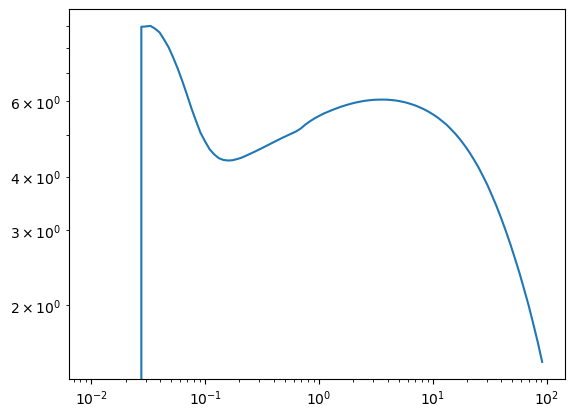

In [16]:
flux_int = (flux3.sum(1).sum(1).sum(1)*geom.pixel_area*u.deg**2*energy_axis_true.edges_min**2).to(u.eV/u.s/u.cm**2)

plt.plot(energy_axis_true.edges_min,flux_int.value)

plt.loglog()


In [17]:
flux_int = (flux3.sum(1).sum(1).sum(1)*geom.pixel_area*u.deg**2*energy_axis_true.edges_min**2).to(u.eV/u.s/u.cm**2)

In [18]:
flux_int

<Quantity [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 8.95802253, 8.9749089 , 9.00234526, 8.86927869,
           8.69092341, 8.36062213, 8.01666444, 7.58711775, 7.14765689,
           6.68393596, 6.22223521, 5.7742773 , 5.39809719, 5.05876026,
           4.83036834, 4.63110737, 4.50629716, 4.4160836 , 4.37385993,
           4.36027148, 4.36583522, 4.39342873, 4.42715818, 4.47564345,
           4.52558331, 4.57818231, 4.63291132, 4.69028743, 4.74936661,
           4.81002153, 4.86943746, 4.92947011, 4.98534853, 5.04241798,
           5.10051324, 5.1800806 , 5.28947492, 5.38360372, 5.46887714,
           5.54144919, 5.61204616, 5.67042626, 5.72828239, 5.78159227,
           5.83188527, 5.87784333, 5.9181205 , 5.95551599, 5.98476413,
           6.01262741, 6.0300332 , 6.04504585, 6.05104186, 6.05287137,
           6.04938303, 6.03731561, 6.02104546, 5.99266072, 5.96216109,
      

/tmp/ipykernel_556088/2531838898.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  main_table[str(iterator)] = i['dphi [1/TeV/cm^2/s]']


energy 133.10078476688366 4.227320012556247e-10
E,[GeV]    F[1 eV/cm^2/s]
30.0   14.436063817368376
35.40109857145194   14.560692552751465
41.77459266885523   14.068375332195572
49.29554909507993   13.145580755634903
58.17055308829244   11.953616146438826
68.64338279448397   10.655172671808334
81.00170535284785   9.375425455007532
95.58497852172913   8.408939013668547
112.79377488659505   7.8104152211089035
133.10078476688366   7.489043579829732
157.06380004900203   7.402526314364587
185.3410355847179   7.4533173683668
218.70920900231948   7.586571859090587
258.08487554584644   7.766831948328851
304.5496039666474   7.959784370530462
359.3796849973311   8.167377787149428
424.08118843892913   8.38542547890259
500.4313318075003   8.602899629971404
590.5272968520102   8.812540157362518
696.8438348330354   9.027985553700628
822.3012428610961   9.391252899170464
970.345578465103   9.683318439701951
1145.043315720523   9.935841879011367
1351.1930429468127   10.152946818787589
1594.45727008067

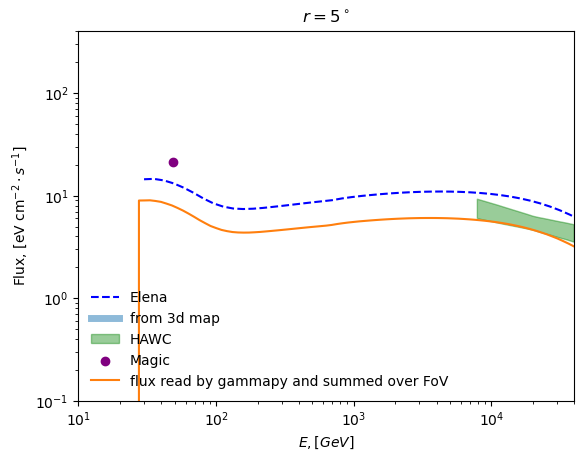

In [39]:
files = sorted(glob.glob("dphi_*.csv"))

Norm = 3.5
name = "default_model_Flux.dat"

tables = []

for i in files:
    test = pd.read_csv(i)
    tables.append(test)


#Read the first table
main_table = pd.read_csv('dphi_theta0.0.csv')

#Adding all other tables to the first one
iterator = 0.1
for i in tables:
    main_table[str(iterator)] = i['dphi [1/TeV/cm^2/s]']
    iterator = round(iterator+0.1,1)
  
main_table.rename(columns={'dphi [1/TeV/cm^2/s]' : '0.0'}, inplace = True)

# Tables to the 2D numpy matrix: 1st [] - row; 2nd [] column
numpy_table = main_table.to_numpy()

# This example gives 1st row and all the columns but the 1st one (the first one is the energy), 
# i.e. all values for the flux 
#print(numpy_table[energy_bin][2:])


Radius=5 #degrees


def f(x):
    return 2*pi*sin(x)


energy_bin = 0
k = 0
flux = 0



Tabs_E_F = None


for i in range(len(numpy_table)):
    energy_bin = i
    radius_deg = 0
    flux=0
    while radius_deg < Radius:
        # res = integrate.quad(f, pi/180 * (k), pi/180 * (k+0.1))[0]
        # precise form for area, better than an approximation
        ring_area = 2*pi * (cos(pi/180 * (radius_deg)) - cos(pi/180 * (radius_deg+0.1)))
        
        if radius_deg<Radius-1:
            flux += Norm * ring_area * (numpy_table[energy_bin][2+int(10*radius_deg)])
            # flux += Norm * ring_area * (numpy_table[energy_bin][2+int(10*radius_deg)]+numpy_table[energy_bin][2+int(10*(radius_deg)+1)])/2
            # flux = flux + Norm * ring_area * (numpy_table[energy_bin][2+int(10*radius_deg)]+numpy_table[energy_bin][2+int(10*(radius_deg+1))])/2
            # flux = flux + Norm * ring_area * (numpy_table[energy_bin][2+int(10*radius_deg)])
        else:
            flux += Norm * ring_area * numpy_table[energy_bin][2+int(10*radius_deg)]
        
        radius_deg = radius_deg + 0.1
        
    #flux=flux/(3.14*Radius**2) 
    
    row = [numpy_table[energy_bin][0],flux]
    
    if Tabs_E_F is not None:
        Tabs_E_F = np.vstack([Tabs_E_F, row])
    else:
        Tabs_E_F = row

    if numpy_table[energy_bin][0] > 133 and numpy_table[energy_bin][0] < 134:
        print("energy", numpy_table[energy_bin][0], flux)
        

# print('Radius',Radius)
# print('E,[GeV]    F[1/TeV/cm^2/s]')
# for i in range(0,len(Tabs_E_F[::,0])):
#     print(str(Tabs_E_F[i,0]), " ", str(Tabs_E_F[i,1]))

# sys.exit()

#Load data from Moskalenko et al 2019

x = []
y = []
# with open('Moskalenko_IC_iso_gamma1_2p0_rz_rt_Inf.csv','r') as csvfile:
#     plots = csv.reader(csvfile, delimiter=',')
#     for row in plots:
#         x.append(float(row[0]))
#         y.append(float(row[1]))

# x1 = []
# y1 = []
# with open('Moskalenko_IC_iso_gamma1_2p0.csv','r') as csvfile:
#     plots = csv.reader(csvfile, delimiter=',')
#     for row in plots:
#         x1.append(float(row[0]))
#         y1.append(float(row[1]))  

x_HAWC_u = []
y_HAWC_u = []
with open('HAWC_upper.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x_HAWC_u.append(float(row[0]))
        y_HAWC_u.append(float(row[1])) 

x_HAWC_l = []
y_HAWC_l = []
with open('HAWC_lower.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x_HAWC_l.append(float(row[0]))
        y_HAWC_l.append(float(row[1]))

x_Magic = []
y_Magic = []
with open('Magic.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        x_Magic.append(float(row[0]))
        y_Magic.append(float(row[1]))
                
Int_HAWC_u=interp1d(x_HAWC_u, y_HAWC_u,fill_value="extrapolate")
Int_HAWC_l=interp1d(x_HAWC_l, y_HAWC_l,fill_value="extrapolate")


plt.figure()
plt.title("$r=5^\\circ$")
#plt.plot(x,y, label='Paper, $\\gamma_1=2.0, r_z, r_t =$ Infinity',color = 'magenta')
#plt.plot(x1,y1, label='Paper, $\\gamma_1=2.0, r_z, r_t =(30,50)$ ',color = 'gray')

plt.plot(Tabs_E_F[::,0], 10**6 * Tabs_E_F[::,1]*Tabs_E_F[::,0]**2, label='Elena', linestyle="--", color = 'b')

with open(name,'w') as outfile:
    print('E,[GeV]    F[1 eV/cm^2/s]')
    for i in range(0,len(Tabs_E_F[::,0])):
        print(str(Tabs_E_F[i,0]), " ", str(10**6 * Tabs_E_F[i,1]*Tabs_E_F[i,0]**2))
        outfile.write(str(Tabs_E_F[i,0]))
        outfile.write('    ')
        outfile.write(str(10**6 * Tabs_E_F[i,1]*Tabs_E_F[i,0]**2))
        outfile.write('\n')
outfile.close()

##

flux_from_2map = fits.open("allenergies.fits")[0].data.sum(1).sum(1)
plt.plot(Tabs_E_F[::,0], 
         10**6 * flux_from_2map*Tabs_E_F[::,0]**2, 
         lw=5,alpha=0.5,
         label="from 3d map")
##

plt.fill_between(x_HAWC_l, Int_HAWC_u(x_HAWC_l),Int_HAWC_l(x_HAWC_l), color='green',alpha=.4,label='HAWC')
plt.scatter(x_Magic,y_Magic,color = 'purple',label='Magic')

plt.plot(energy_axis_true.edges_min*1000, 
         flux_int.value, 
         label="flux read by gammapy and summed over FoV")

plt.xscale("log")
plt.yscale("log")

plt.xlim(10, 4e4)
plt.ylim(0.1, 400)
plt.legend(frameon=False, loc='lower left')
plt.xlabel("$E, [GeV]$")
plt.ylabel("Flux, [eV cm$^{-2} \cdot s^{-1}$]")

plt.show()

# Spectrum of IC emission averaged over a 10° wide region

<Axes: xlabel='Energy [TeV]', ylabel='norm []'>

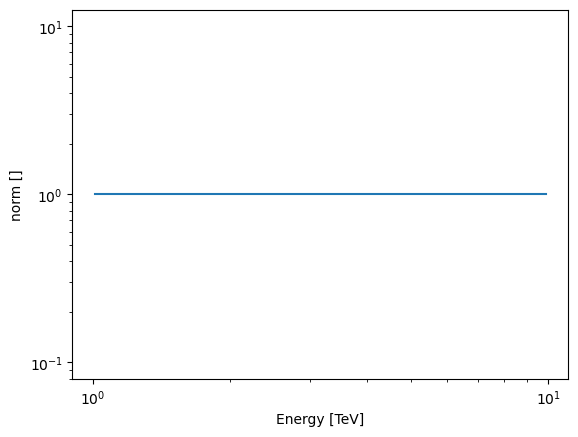

In [40]:
Geminga_model.spectral_model.plot(energy_bounds=[1*u.TeV, 10*u.TeV]) #.to(u.erg) #/u.cm**2/u.s)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 98.5 deg, 17.8 deg

	deadtime fraction : 0.0%

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 19099451 
  Total background counts         : 19075642.34
  Total excess counts             : 23808.66

  Predicted counts                : 19105262.05
  Predicted background counts     : 19075642.34
  Predicted excess counts         : 29619.70

  Exposure min                    : 1.68e+03 m2 s
  Exposure max                    : 5.69e+11 m2 s

  Number of total bins            : 800000 
  Number of fit bins              : 800000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -149598297.10

  Number of models                : 2 
  Number of parameters            : 6
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name            

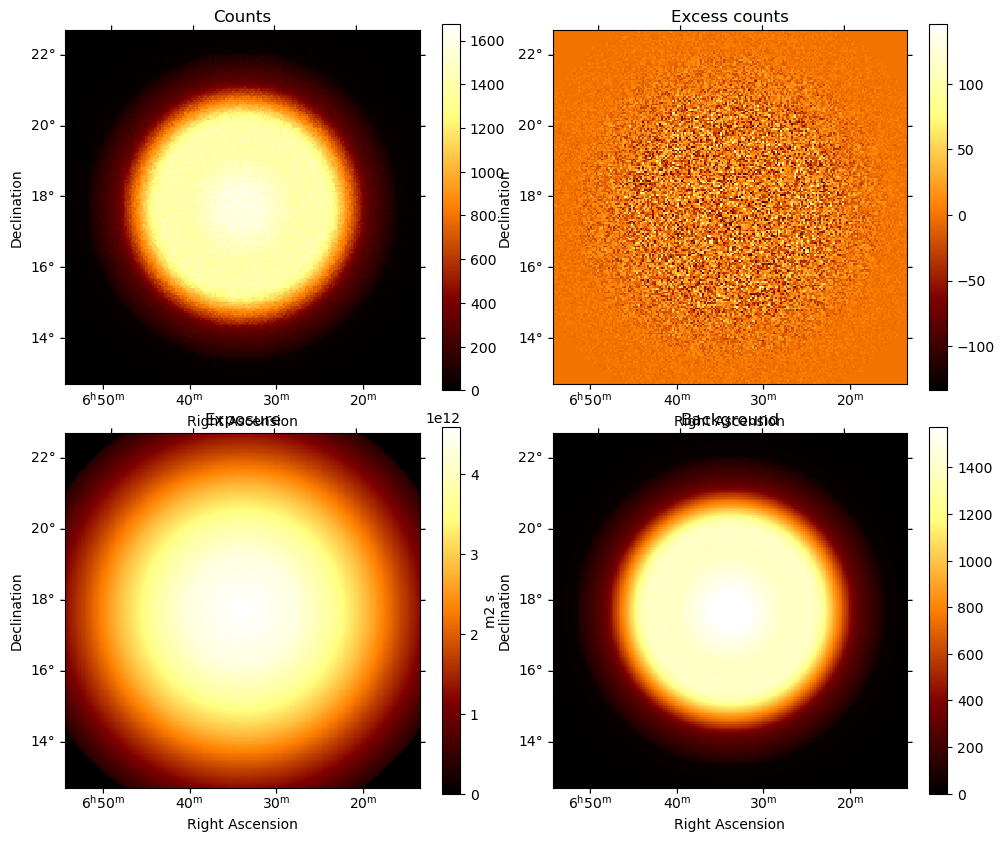

In [67]:
# empty = MapDataset.create(geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis, name="dataset-simu")

geom_notrue = WcsGeom.create(
    skydir=pointing,
    width=(10, 10),
    binsz=0.05,
    frame="icrs",
    axes=[energy_axis],
)



empty = MapDataset.create(geom_notrue, name="dataset-simu")


obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

# maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=5.0 * u.deg)

dataset = maker.run(empty, obs)
# dataset = maker_safe_mask.run(dataset, obs)

dataset.models = models

dataset.fake()

print(dataset)

dataset.peek()

In [ ]:
dataset_on_off = MapDatasetOnOff.from_map_dataset(
    dataset=dataset, acceptance=.1, acceptance_off=5
)

dataset_spectrum_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=spectrum_dataset, acceptance=1, acceptance_off=5
)

dataset_on_off.counts.data.max(), dataset_on_off.counts_off.data.max()

In [ ]:
dataset_on_off.peek()

array([[<WCSAxes: title={'center': 'Energy 30.0 GeV - 42.4 GeV'}>,
        <WCSAxes: title={'center': 'Energy 42.4 GeV - 59.9 GeV'}>,
        <WCSAxes: title={'center': 'Energy 59.9 GeV - 84.6 GeV'}>],
       [<WCSAxes: title={'center': 'Energy 84.6 GeV - 119 GeV'}>,
        <WCSAxes: title={'center': 'Energy 119 GeV - 169 GeV'}>,
        <WCSAxes: title={'center': 'Energy 169 GeV - 238 GeV'}>],
       [<WCSAxes: title={'center': 'Energy 238 GeV - 337 GeV'}>,
        <WCSAxes: title={'center': 'Energy 337 GeV - 475 GeV'}>,
        <WCSAxes: title={'center': 'Energy 475 GeV - 672 GeV'}>],
       [<WCSAxes: title={'center': 'Energy 672 GeV - 949 GeV'}>,
        <WCSAxes: title={'center': 'Energy 949 GeV - 1.34 TeV'}>,
        <WCSAxes: title={'center': 'Energy 1.34 TeV - 1.89 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 1.89 TeV - 2.67 TeV'}>,
        <WCSAxes: title={'center': 'Energy 2.67 TeV - 3.78 TeV'}>,
        <WCSAxes: title={'center': 'Energy 3.78 TeV - 5.33 TeV'}>],
    

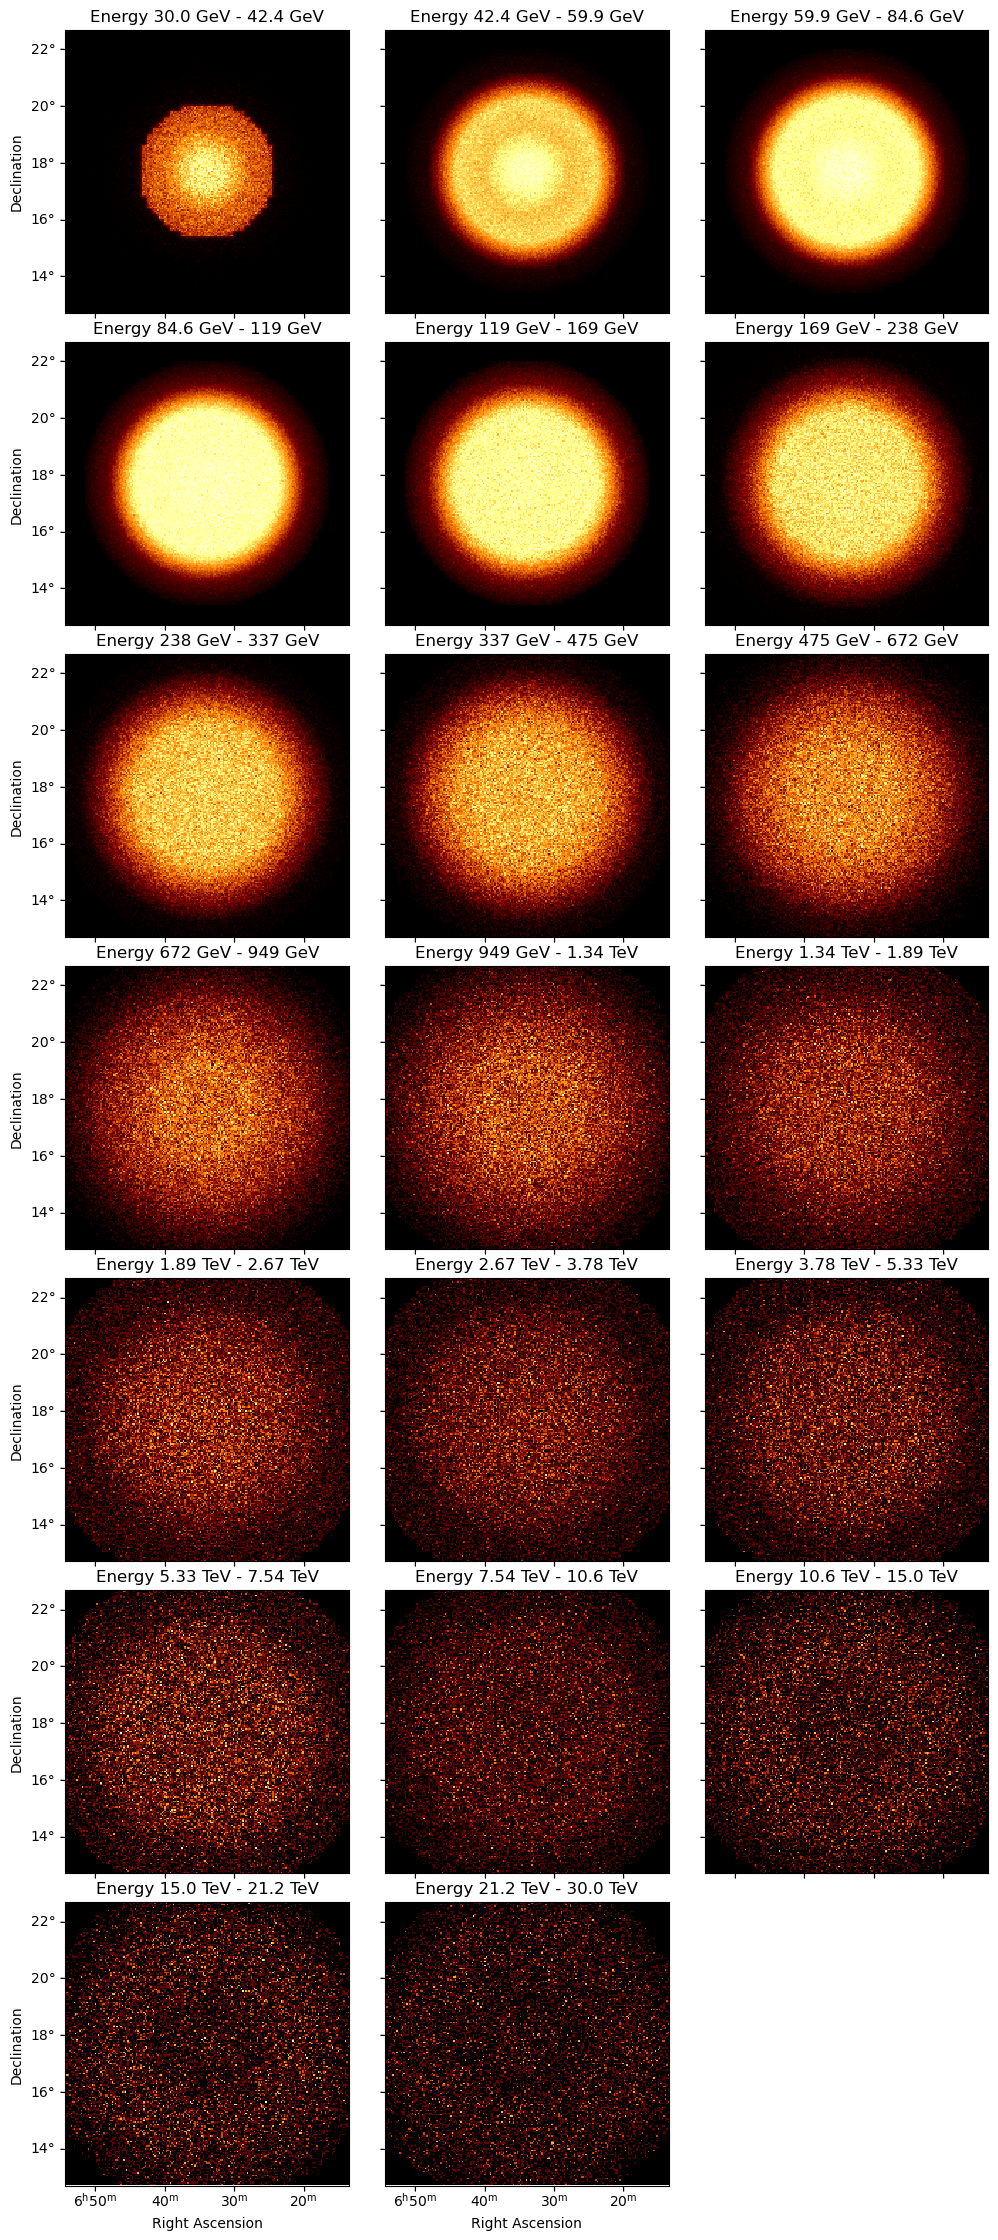

In [80]:
dataset.counts.plot_grid()

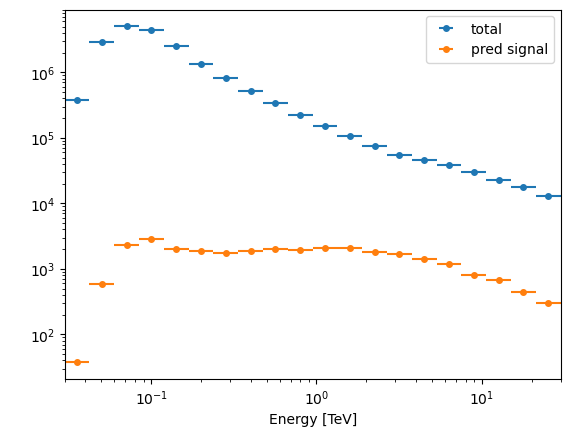

In [76]:
dataset.counts.get_spectrum().plot(label="total")
dataset.npred_signal().get_spectrum().plot(label="pred signal")
plt.legend()


In [ ]:
sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10
)
sensitivity_table = sensitivity_estimator.run(dataset_on_off)

In [ ]:
sensitivity_table['excess']

In [ ]:
dataset_on_off.counts.data

In [ ]:

spectrum_sensitivity_estimator = SensitivityEstimator(
    gamma_min=10, n_sigma=5, bkg_syst_fraction=0.10, 
    # spectrum= PowerLawSpectralModel(index=2.7, amplitude="1 cm-2 s-1 TeV-1")
    # spectrum=Geminga_model.spectral_model
)
spectrum_sensitivity_table= spectrum_sensitivity_estimator.run(dataset_spectrum_on_off)

In [ ]:
emin_cta, flux_cta = np.loadtxt('CTA_point_source_left.txt',unpack=True) # E[TeV], E^2 * Flux Sensitivity [erg cm^2/s]
emax_cta, flux_cta = np.loadtxt('CTA_point_source_right.txt',unpack=True)
emean_cta, flux_cta = np.loadtxt('CTA_point_source_mean.txt',unpack=True)

In [ ]:
# check this out, data for 
# https://zenodo.org/record/5499840#.YUya5WYzbUI
# https://docs.gammapy.org/1.0.1/tutorials/analysis-1d/cta_sensitivity.html?highlight=sensitivity

In [ ]:
# Show the results table
display(sensitivity_table)

# Save it to file (could use e.g. format of CSV or ECSV or FITS)
# sensitivity_table.write('sensitivity.ecsv', format='ascii.ecsv')

# Plot the sensitivity curve
t = sensitivity_table

is_s = t["criterion"] == "significance"

fig, ax = plt.subplots()
ax.plot(
    spectrum_sensitivity_table["energy"],    
    spectrum_sensitivity_table["e2dnde"],
    "s-",
    color="black",
    label="spectrum dtaset",
)

ax.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
ax.plot(t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma")
is_bkg_syst = t["criterion"] == "bkg"
ax.plot(
    t["energy"][is_bkg_syst],
    t["e2dnde"][is_bkg_syst],
    "v-",
    color="green",
    label="bkg syst",
)

plt.errorbar(emean_cta[2:-1],flux_cta[2:-1],label='CTA point source 50h')


ax.loglog()
ax.set_xlabel(f"Energy [{t['energy'].unit}]")
ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit}]")
ax.legend()

In [ ]:
# Plot expected number of counts for signal and background
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(t["energy"], t["background"], "o-", color="black", label="blackground")

ax1.loglog()
ax1.set_xlabel(f"Energy [{t['energy'].unit}]")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius [{on_radii.unit}]", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)
plt.show()